In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [107]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2

In [108]:
face_dir = '/content/drive/MyDrive/facedata/dataset'

In [139]:
from imutils import paths
imagePaths = list(paths.list_images(face_dir))
data = []
data_gray = []
labels = []

for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  image = cv2.imread(imagePath)
  
  image_real = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  image_real = cv2.resize(image_real, dsize=(224,224))
  image_gray = cv2.resize(image_gray, dsize=(224,224))

  data.append(image_real)
  data_gray.append(image_gray)
  labels.append(label)

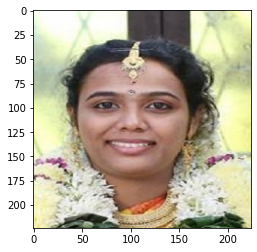

In [110]:
plt.imshow(data[2])

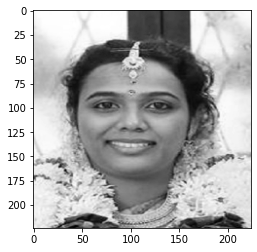

In [46]:
plt.imshow(data_gray[2], cmap='gray')

In [111]:
data[2].shape, data_gray[2].shape

((224, 224, 3), (224, 224))

In [112]:
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/facedata/haarcascade_frontalface_default.xml')

In [113]:
from matplotlib.patches import Rectangle

def facefind(gray):
  faces = face_cascade.detectMultiScale(gray) #얼굴 탐지, 좌표 반환(x,y,w,h)
  if len(faces) != 0: #len(faces) 사진에서 얼굴의 수
    
    for (x,y,w,h) in faces:
      plt.imshow(gray, cmap='gray')
      plt.gca().add_patch(Rectangle((x,y),w,h,linewidth=3,edgecolor='r',facecolor='none'))  #얼굴 위치 표시
    return len(faces)
  else:
    return 0

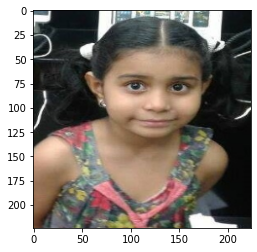

In [140]:
plt.imshow(data[5])

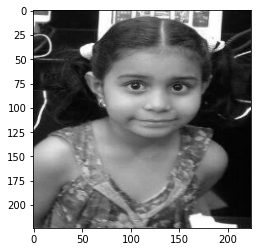

In [142]:
plt.imshow(data_gray[5], cmap='gray')

1

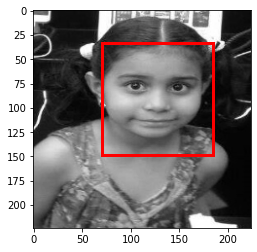

In [114]:
facefind(data_gray[5])

In [115]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
labels = to_categorical(labels)

In [116]:
data[2].shape

(224, 224, 3)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)

In [118]:
EPOCHS = 20
BS = 32

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

x = mobilenet.output
x = MaxPooling2D(pool_size=(7,7))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(2, activation="softmax")(x)

model = Model(inputs=mobilenet.input, outputs=x)

for layer in mobilenet.layers:
	layer.trainable = False

model.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-4), metrics=["accuracy"])

H = model.fit(
	aug.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) / BS,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) / BS,
	epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
34/34 [==============================] - 55s 1s/step - loss: 1.3278 - accuracy: 0.5673 - val_loss: 0.6295 - val_accuracy: 0.6667
Epoch 2/20
34/34 [==============================] - 50s 1s/step - loss: 0.8064 - accuracy: 0.6436 - val_loss: 0.4951 - val_accuracy: 0.8333
Epoch 3/20
34/34 [==============================] - 51s 1s/step - loss: 0.5977 - accuracy: 0.7145 - val_loss: 0.4653 - val_accuracy: 0.8442
Epoch 4/20
34/34 [==============================] - 51s 1s/step - loss: 0.5438 - accuracy: 0.7573 - val_loss: 0.4226 - val_accuracy: 0.8659
Epoch 5/20
34/34 [==============================] - 51s 1s/step - loss: 0.5345 - accuracy: 0.7400 - val_loss: 0.4069 - val_accuracy: 0.8623
Epoch 6/20
34/34 [==============================] - 50s 1s/step - loss: 0.5149 - accuracy: 0.7564 - val_loss: 0.3866 - val_accuracy: 0.8587
Epoch 7/20
34/34 [==============================] - 50s 1s/step - loss: 0.4667 - accuracy: 0.8073 - val_loss: 0.3493 - val_accuracy: 0.9022
Epoch 8/20
34/34 [==

In [119]:
y_pred = model.predict(X_test)

print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       138
           1       0.96      0.88      0.92       138

    accuracy                           0.92       276
   macro avg       0.93      0.92      0.92       276
weighted avg       0.93      0.92      0.92       276



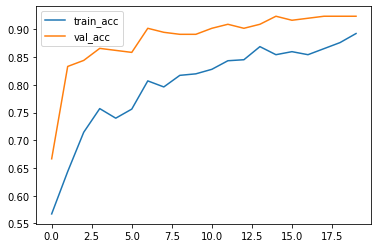

In [121]:
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.legend()

In [155]:
test_data_real = []
test_data_gray = []
test_num = ['1','2','3','4','5']
for i in test_num:

  imagePath = '/content/mask_test' + i + '.jpg'
  image = cv2.imread(imagePath)
  
  image_real = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  image_real = cv2.resize(image_real, dsize=(224,224))
  image_gray = cv2.resize(image_gray, dsize=(224,224))

  test_data_real.append(image_real)
  test_data_gray.append(image_gray)

In [156]:
test_data_real = np.array(test_data_real)

In [152]:
X_test.shape

(276, 224, 224, 3)

In [153]:
test_data_real.shape

(5, 224, 224, 3)

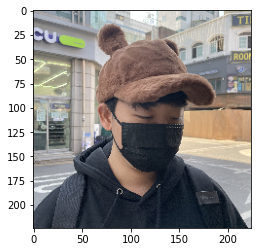

In [131]:
plt.imshow(test_data_real[0])

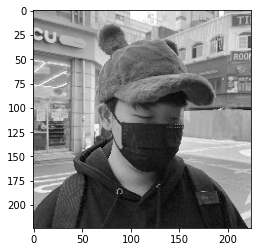

In [133]:
plt.imshow(test_data_gray[0], cmap='gray')

얼굴 탐지 x


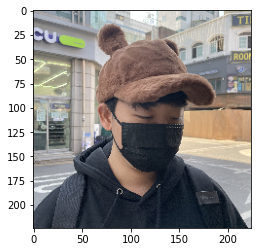

마스크 미착용


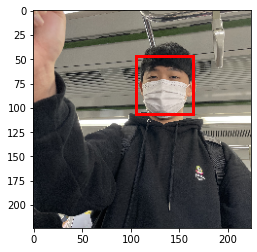

마스크 미착용


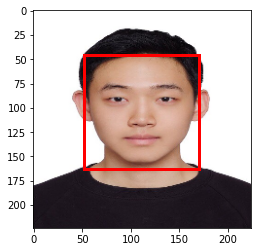

얼굴 탐지 x


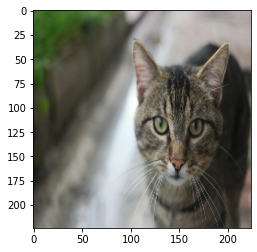

마스크 미착용


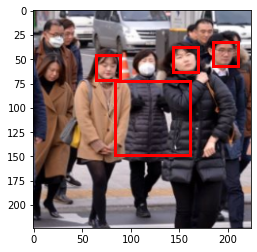

In [158]:
test_pred = model.predict(test_data_real)
for i in range(5):
  test_image = test_data_real[i]
  if facefind(test_data_gray[i]):
    print("마스크 착용") if(np.argmax(test_pred[i])) else print("마스크 미착용")
    np.argmax(test_pred[i])
  else:
    print("얼굴 탐지 x")
  plt.imshow(test_image)
  plt.show()

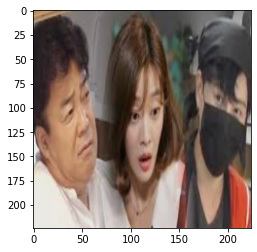

In [148]:
plt.imshow(test_data_real[4])

2

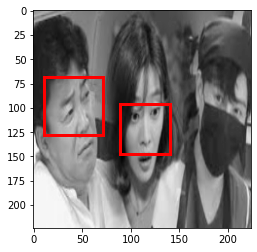

In [149]:
facefind(test_data_gray[4])